# Remote Job Market Scraping & Analysis (RemoteOK)

This notebook demonstrates **end-to-end web scraping, data cleaning, and analysis** 
of remote job postings from [RemoteOK](https://remoteok.com/).

**Objectives:**
- Scrape live job postings (title, company, skills, salary, location, date).
- Clean and structure the dataset.
- Perform **Exploratory Data Analysis (EDA)** to identify:
  - Most in-demand skills
  - Top hiring companies
  - Salary ranges
  - Job posting trends over time

**Tech Stack:** Python, Selenium, Pandas, Matplotlib, Seaborn


##  Step 1: Import Libraries

We import Selenium for scraping, Pandas for data handling, 
and Matplotlib/Seaborn for visualizations.


In [35]:
#Import Libraries
import pandas as pd
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager


##  Step 2: Set Up Selenium WebDriver and Scrapping data

We configure Chrome in headless mode to scrape job postings 
without opening a browser window. 
Additional flags (`--no-sandbox`, `--disable-dev-shm-usage`) 
are added for stability in containerized environments.

We target job rows (`<tr class="job">`) and extract:
- Job Title
- Company
- Date Posted
- Skills (tags)
- Location
- Salary (if available)

This produces a raw dataset.

In [4]:
# Set up chrome web driver
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# set defaault url
url = "https://remoteok.com/remote-data-scientist-jobs"
driver.get(url)

# Wait for jobs to load
wait = WebDriverWait(driver, 15)
job_rows = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "tr.job")))

# Scroll to load more
for _ in range(3):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

jobs = []
for row in driver.find_elements(By.CSS_SELECTOR, "tr.job"):
    try:
        title = row.find_element(By.TAG_NAME, "h2").text
        company = row.find_element(By.TAG_NAME, "h3").text
        date_posted = row.find_element(By.TAG_NAME, "time").get_attribute("datetime")

        # To get the tags
        tags = [tag.text for tag in row.find_elements(By.CSS_SELECTOR, ".tag")]
        
        # Extract job locations and salaries
        locations = row.find_elements(By.CSS_SELECTOR, ".location")
        location = locations[0].text if len(locations) > 0 else None
        salary = locations[1].text if len(locations) > 1 else None
        
        jobs.append({
            "title": title,
            "company": company,
            "date_posted": date_posted,
            "tags": tags,
            "location": location,
            "salary": salary
        })
    except:
        pass

driver.quit()

# Create dataFrame 
df = pd.DataFrame(jobs)

# Export data to a csv file
df.to_csv("remoteok_jobs.csv", index=False)


In [12]:
df.head(11)

,title,company,date_posted,tags,location,salary
0,$1000 Weekly Work from Home,MasterCraft Boating Company,2025-08-21T01:14:09+00:00,"[Sales, Customer Support, Admin, , , , , , ]",🇺🇸 United States,💰 $120k - $160k
1,Senior Full Stack Engineer,Aguru UK,2025-09-06T15:10:56+00:00,"[Engineer, Developer, Technical, ]",🇪🇺 Europe,🇬🇧 United Kingdom
2,Senior DevOps Engineer,Aguru UK,2025-09-06T14:38:18+00:00,"[Engineer, Technical, Backend, ]",🇪🇺 Europe,🇬🇧 United Kingdom
3,Social Media Manager & Shitposter @ Fun Ecom Co,JLS Trading Co,2025-09-06T11:34:45+00:00,"[Marketing, Full Time, Remote, ]",🌏 Worldwide,💰 $20k - $60k
4,Mid level Backend Dev for SaaS the music industry,MelodyIQ,2025-09-05T06:16:35+00:00,"[Developer, JavaScript, React, , , ]",🌏 Worldwide,💰 $80k - $100k
5,Online Data Research with Bonus,TELUS Digital,2025-09-04T08:55:40+00:00,"[Entry-Level, Computer, Online, , , , , , , ]",🇺🇸 United States,💰 $10k - $20k
6,Python Developer,Ampcontrol,2025-08-27T15:24:06+00:00,"[Developer, Python, English, , ]",🇪🇺 Europe,💃 Latin America
7,UX Engineer,Baymard Institute,2025-08-26T08:36:58+00:00,"[Front End, JavaScript, React, , , , , ]",🇪🇺 Europe 🔒,🇬🇧 United Kingdom 🔒
8,DeFi Analyst and Educator,Decentralized Masters,2025-08-22T13:22:49+00:00,"[Edu, Teaching, Crypto, ]",🌏 Worldwide,💰 $40k - $100k
9,Engineering Lead,Aragon,2025-08-28T12:00:03+00:00,"[Design, Osx, Web3, , , , , , , , , , , , , ]",🌏 Worldwide,💰 $60k - $140k*


## Step 3: Data Cleaning

We clean and normalize the data:
- **Skills (`tags`)**: Flatten into individual skills for analysis.
- **Salary**: Parse ranges into numeric min/max values.
- **Location**: Remove emojis and normalize.
- **Titles**: Strip symbols and whitespace.


In [ ]:
# Ensure tag is always a list
df["tags"] = df["tags"].apply(lambda x: x if isinstance(x, list) else [])

# Split tags that are joined in one string by commas
cleaned_tags = []
for row in df["tags"]:
    if isinstance(row, list):
        for tag in row:
            # strip on commas and strip spaces
            for t in tag.split(","):
                t = t.strip()
                if t:
                    cleaned_tags.append(t)

# Put flattened skills into a new DataFrame
skills_df = pd.DataFrame(cleaned_tags, columns=["skill"])

# Normalize (lowercase, remove spcial characters)
skills_df["skill"] = (skills_df["skill"]
    .str.lower()
    .str.replace(r"[^a-zA-Z0-9+ ]", "", regex = True)
)
skills_df.head()

In [11]:
skills_df.nunique()

skill    91
dtype: int64

## Parse salary column

In [13]:
def parse_salary(s):
    """
    parse salary column and separate minimum and maximum salary to new columns
    Parameters:
    s - salary to parse

    Returns parsed salary
    
    """

    if not s or not isinstance(s, str):
        return None, None

    # Remove emojis and spaces
    s = s.replace("💰", "").strip()

    # Find numbers with k or digits
    match = re.findall(r"(\d+)[kK]", s)
    if len(match) >= 2:
        return int(match[0])* 1000, int(match[1]) * 1000
    elif len(match) == 1:
        return int(match[0])* 1000, None

df[["salary_min", "salary_max"]] = df["salary"].apply(lambda x: pd.Series(parse_salary(x)))

In [26]:
df.head()

,company,date_posted,tags,salary_min,salary_max,location_clean,title_clean
0,MasterCraft Boating Company,2025-08-21T01:14:09+00:00,"[Sales, Customer Support, Admin, , , , , , ]",120000.0,160000.0,United States,1000 Weekly Work from Home
1,Aguru UK,2025-09-06T15:10:56+00:00,"[Engineer, Developer, Technical, ]",NaN,NaN,Europe,Senior Full Stack Engineer
2,Aguru UK,2025-09-06T14:38:18+00:00,"[Engineer, Technical, Backend, ]",NaN,NaN,Europe,Senior DevOps Engineer
3,JLS Trading Co,2025-09-06T11:34:45+00:00,"[Marketing, Full Time, Remote, ]",20000.0,60000.0,Worldwide,Social Media Manager Shitposter Fun Ecom Co
4,MelodyIQ,2025-09-05T06:16:35+00:00,"[Developer, JavaScript, React, , , ]",80000.0,100000.0,Worldwide,Mid level Backend Dev for SaaS the music industry


In [23]:
# Preprocess
def preprocess(df):
    # Normalize location
    df["location_clean"] = df["location"].str.replace(r"[^\w\s]", "", regex = True).str.strip()

    # Clean title
    df["title_clean"] = df["title"].str.replace(r"[^\w\s]", "", regex = True).str.strip()

    # drop cols 
    df.drop(columns = ["title", "location", "salary"], inplace = True)
    
    return df

In [33]:
df_clean = preprocess(df)

In [34]:
df_clean.head()

,company,date_posted,tags,salary_min,salary_max,location_clean,title_clean
0,MasterCraft Boating Company,2025-08-21T01:14:09+00:00,"[Sales, Customer Support, Admin, , , , , , ]",120000.0,160000.0,United States,1000 Weekly Work from Home
1,Aguru UK,2025-09-06T15:10:56+00:00,"[Engineer, Developer, Technical, ]",NaN,NaN,Europe,Senior Full Stack Engineer
2,Aguru UK,2025-09-06T14:38:18+00:00,"[Engineer, Technical, Backend, ]",NaN,NaN,Europe,Senior DevOps Engineer
3,JLS Trading Co,2025-09-06T11:34:45+00:00,"[Marketing, Full Time, Remote, ]",20000.0,60000.0,Worldwide,Social Media Manager Shitposter Fun Ecom Co
4,MelodyIQ,2025-09-05T06:16:35+00:00,"[Developer, JavaScript, React, , , ]",80000.0,100000.0,Worldwide,Mid level Backend Dev for SaaS the music industry


## Exploratory Data Analysis (EDA)

We answer business-driven questions:

1. **What are the top 20 most in-demand skills?**
2. **Which companies are hiring the most?**
3. **Where are jobs located?**
4. **What salary ranges are offered?**
5. **How has demand changed over time?**

Each insight is supported with plots.


C:\Users\User\AppData\Local\Temp\ipykernel_19600\2281485167.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_skills.values, y=top_skills.index, palette="viridis")


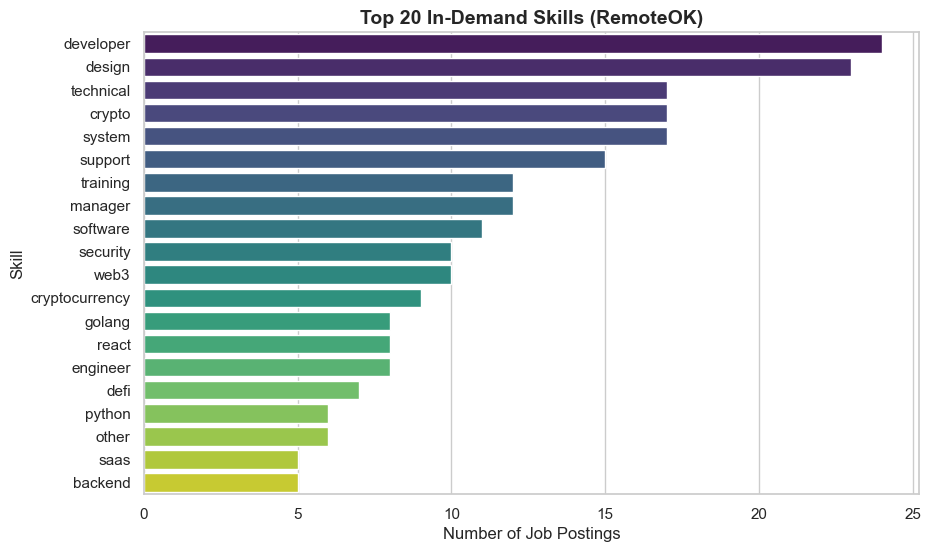

C:\Users\User\AppData\Local\Temp\ipykernel_19600\2281485167.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette="mako")


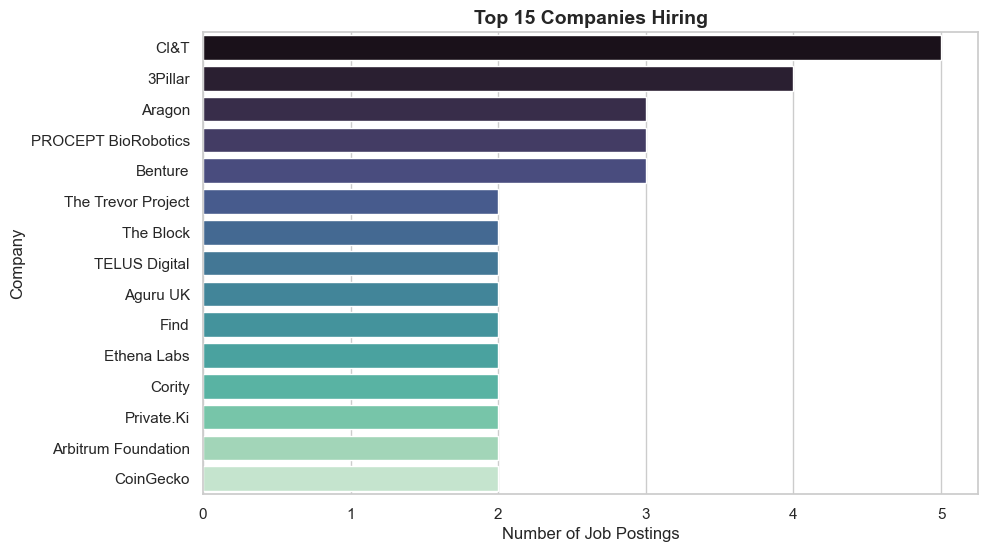

C:\Users\User\AppData\Local\Temp\ipykernel_19600\2281485167.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette="cubehelix")


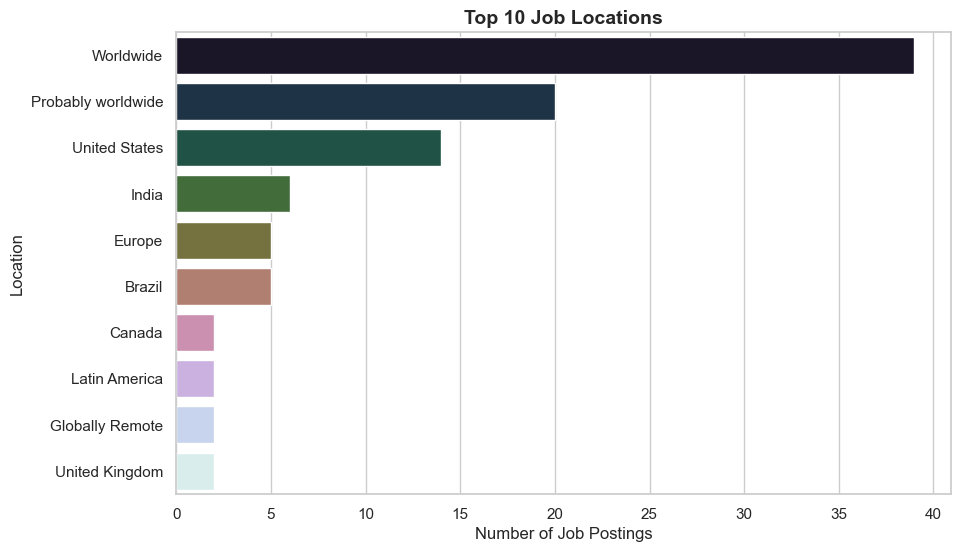

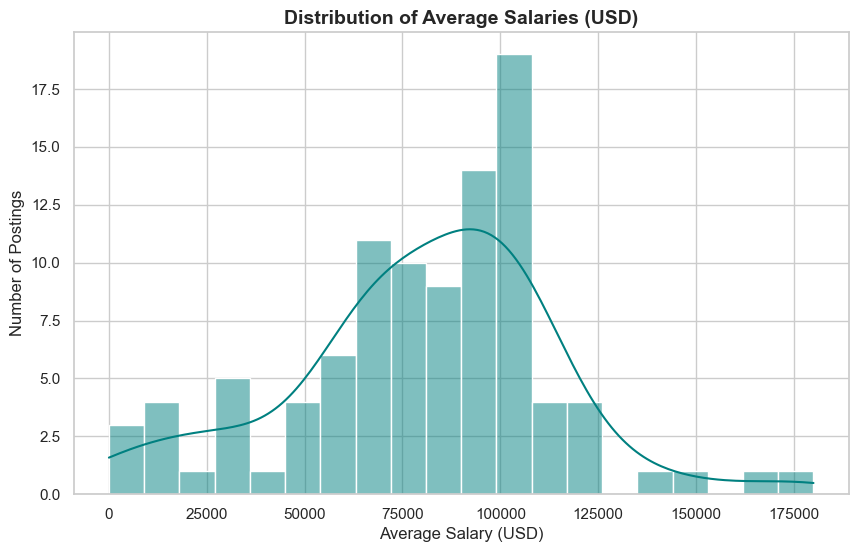

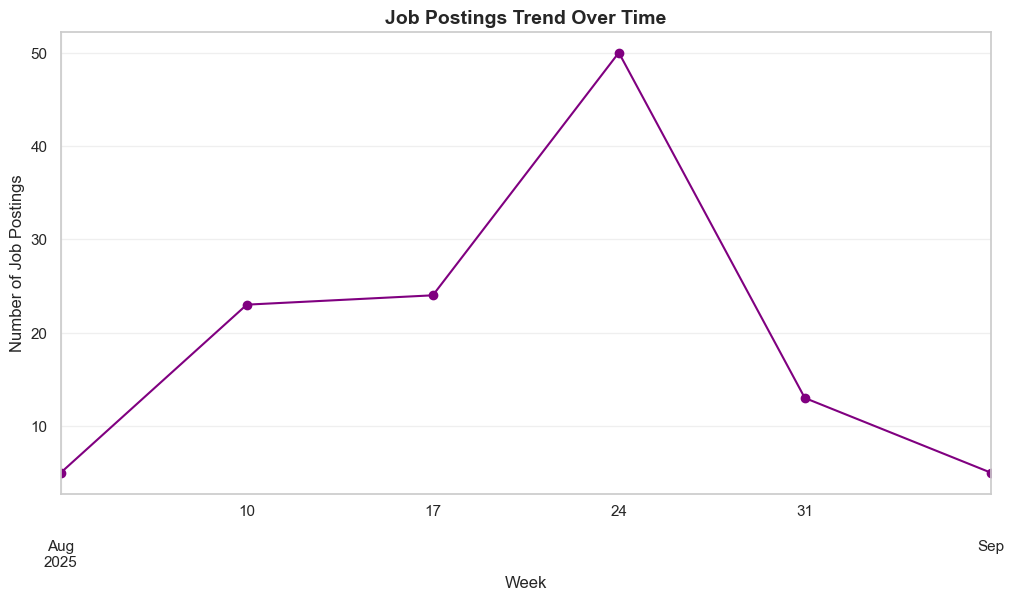

In [50]:
# Top 20 skills
top_skills = skills_df['skill'].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_skills.values, y=top_skills.index, palette="viridis")
plt.title("Top 20 In-Demand Skills (RemoteOK)", fontsize=14, weight='bold')
plt.xlabel("Number of Job Postings")
plt.ylabel("Skill")
plt.show()


#Top 15 Hiring Companies
top_companies = df['company'].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_companies.values, y=top_companies.index, palette="mako")
plt.title("Top 15 Companies Hiring", fontsize=14, weight='bold')
plt.xlabel("Number of Job Postings")
plt.ylabel("Company")
plt.show()


#Job Postings by Location
top_locations = df['location_clean'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="cubehelix")
plt.title("Top 10 Job Locations", fontsize=14, weight='bold')
plt.xlabel("Number of Job Postings")
plt.ylabel("Location")
plt.show()


#Salary Distribution
# Drop rows with no salary info
salary_data = df[['salary_min','salary_max']].dropna()

# Create a column for average salary per job
salary_data['salary_avg'] = salary_data[['salary_min','salary_max']].mean(axis=1)

plt.figure(figsize=(10,6))
sns.histplot(salary_data['salary_avg'], bins=20, kde=True, color="teal")
plt.title("Distribution of Average Salaries (USD)", fontsize=14, weight='bold')
plt.xlabel("Average Salary (USD)")
plt.ylabel("Number of Postings")
plt.show()


# Job Postings Over Time  
# Convert date_posted to datetime
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Group by week
jobs_over_time = df.groupby(pd.Grouper(key='date_posted', freq='W')).size()

plt.figure(figsize=(12,6))
jobs_over_time.plot(kind='line', marker='o', color='purple')
plt.title("Job Postings Trend Over Time", fontsize=14, weight='bold')
plt.xlabel("Week")
plt.ylabel("Number of Job Postings")
plt.grid(True, alpha=0.3)
plt.show()
